# load all datasets and run standard preprocessing steps, saving pickle for use locally or on cluster

In [1]:
import sys
sys.path.insert(0, '../../flygenvectors/')

import os
import numpy as np
from glob import glob
import pickle
import copy
from importlib import reload
import pdb
import shutil

import scipy.io as sio
from scipy import sparse, signal
from scipy.stats import zscore

from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from skimage.restoration import denoise_tv_chambolle

import matplotlib.pyplot as plt
from matplotlib import axes, gridspec, colors
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import data as dataUtils
import regression_model as model
import plotting
import flygenvectors.ssmutils as utils
import flygenvectors.utils as futils


# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png', 'pdf')

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

In [116]:
dirs = futils.get_dirs()

# datasets of just running
exp_list_full = [
            ['2018_08_24','fly3_run1'],
            ['2018_08_24','fly2_run2'],
            ['2019_07_01','fly2'],
            ['2019_10_14','fly3'],
            ['2019_06_28','fly2'],
            ['2019_06_30','fly1'],
            ['2019_10_21','fly1'],
            ['2019_10_10','fly3'],
            ['2019_08_14','fly1']]

# datasets of running and flailing
exp_list_split = [
            ['2019_04_18','fly2'],
            ['2019_04_22','fly1'],
            ['2019_04_24','fly1'],
            ['2019_05_07','fly1']]


## choose which list to process

In [117]:
split_behav = False
if split_behav:
    exp_list = exp_list_split
else:
    exp_list = exp_list_full


## set behav params and check that they're correct

In [115]:
sig_list = {
    '2019_04_18_fly2': [.5,.5,.5],
    '2019_04_22_fly1': [.5,3,3,3],
    '2019_04_24_fly1': [.5,3,3],
    '2019_05_07_fly1': [2,6],
    '2018_08_24_fly3_run1':[.5,.5,.5],
    '2018_08_24_fly2_run2':[.5,.5,.5],
    '2019_07_01_fly2':[2,2,2],
    '2019_10_14_fly3':[1,1,1],
    '2019_06_28_fly2':[2,2,2],
    '2019_06_30_fly1':[2,2,2,2],
    '2019_10_21_fly1':[1.5,1.5,1.5],
    '2019_10_10_fly3':[2,2,2,2,2,2],
    '2019_08_14_fly1':[1.5,1.5,1.5,2,3,3]
}

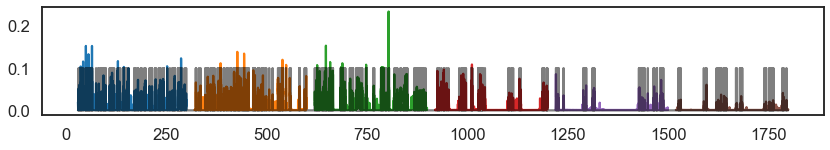

In [68]:
nf = 8
data_tot = []
n_flies = len(exp_list)
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
data_dict_raw = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])
    

data_dict=copy.deepcopy(data_dict_raw)
beh = np.zeros(data_dict['ball'].shape)
U = np.unique(data_dict['trialFlag'])
sig = sig_list[expt_id]

plt.figure(figsize=(14,2))
for i in range(len(U)):
    uid = data_dict['trialFlag'][:,0]==U[i]
    beh[uid] = dataUtils.binarize_timeseries_by_outliers(data_dict['ball'][uid], sig=sig[i]) #0.5
    plt.plot(data_dict['time'][uid], data_dict['ball'][uid,:])
plt.plot(data_dict['time'], .1*beh, 'k', alpha=.5)
plt.show()



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b6871aac8>,
      dtype=object)

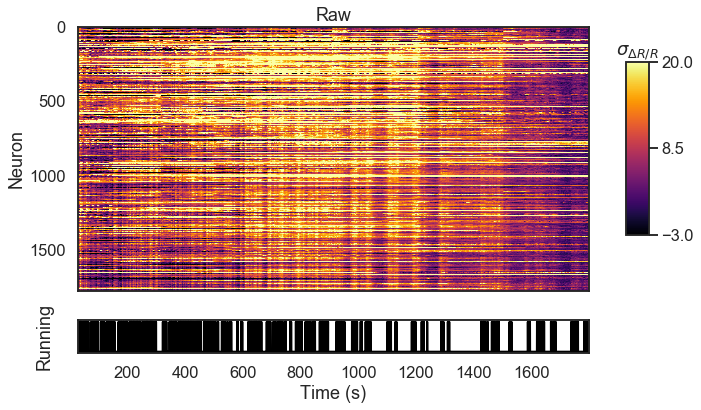

In [69]:
data_dict['tPl']=data_dict['time']
data_dict['behavior']=beh
plotting.show_raster_with_behav(data_dict,color_range=(-3,20),include_feeding=False,include_dlc=False)


# process datasets

In [118]:
# exp_list = [exp_list[5]]
for nf in range(len(exp_list)):
    print(str(nf)+' of '+str(len(exp_list)-1))
    
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])

    # behavior
    beh = np.zeros(data_dict['ball'].shape)
    U = np.unique(data_dict['trialFlag'])
    sig = sig_list[expt_id]
    for i in range(len(U)):
        uid = data_dict['trialFlag'][:,0]==U[i]
        beh[uid] = dataUtils.binarize_timeseries_by_outliers(data_dict['ball'][uid], sig=sig[i]) #0.5
    data_dict['ball'] = beh.copy()
    data_dict['tPl'] = data_dict['time'].copy()
    data_dict['behavior'] = beh.copy()
    if len(data_dict['beh_labels'])==0:
        data_dict['beh_labels'] = beh.copy()

    # run full processing
    ro = model.reg_obj(exp_id=expt_id, 
                   data_dict=copy.deepcopy(data_dict),
                   fig_dirs=fig_dirs,
                   split_behav=split_behav)
    ro.data_dict = ro.preprocess()
    pickle.dump( ro.data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )


0 of 0
0% 6% 13% 20% 27% 34% 41% 48% 55% 62% 69% 76% 83% 90% 97% 

In [ ]:
plotting.show_raster_with_behav(data_dict,color_range=(-3,20),include_feeding=False,include_dlc=False)


In [119]:
# temporarily copy pkls to one location for convenient export (to cluster)
staging_folder = '/Users/evan/Desktop/'+'flygenvectors_pkl_copy/'
# os.mkdir(staging_folder)

for nf in range(len(exp_list)):
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    filename = fig_dirs['pkl_dir'] + expt_id +'_dict.pkl'
    shutil.copy(filename, staging_folder)

In [120]:
os.listdir(staging_folder)

['2019_07_01_fly2_dict.pkl',
 '2019_10_21_fly1_dict.pkl',
 '2019_10_14_fly3_dict.pkl',
 '2019_10_10_fly3_dict.pkl',
 '2019_08_14_fly1_dict.pkl',
 '2019_06_30_fly1_dict.pkl',
 '2019_06_28_fly2_dict.pkl',
 '2018_08_24_fly2_run2_dict.pkl',
 '2018_08_24_fly3_run1_dict.pkl']